<a href="https://colab.research.google.com/github/gunjanak/Commercial_banks_Nepse/blob/main/main_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Libraries***

In [ ]:
!pip3 install requests_html bs4

     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 138 kB 28.2 MB/s 
     |████████████████████████████████| 103 kB 45.4 MB/s 
     |████████████████████████████████| 127 kB 53.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=b26cdf6b2dad5c14faa4dbd5fac1421553fccc0b85fc3ce21e2a91469c7d375c
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=3c26c71b18904ad03805e852a32c355d013c8d242111eb9cee5354e7a79d2c64
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built fake-useragent parse
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not

In [ ]:
from bs4 import BeautifulSoup
from requests_html import HTMLSession
#using regex to format string
import re 
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
import time

***Web Scrapping***

In [ ]:
def price_history(company_name,Start_date):
  # initialize an HTTP session
  session = HTMLSession()
  url = "https://www.nepalipaisa.com/Modules/CompanyProfile/webservices/CompanyService.asmx/GetCompanyPriceHistory"
  max_limit = 5000
#  Start_date = "2011-12-15"
  #End_date = "2020-12-15"
  End_date = datetime.today().strftime('%Y-%m-%d')

  data = {"StockSymbol": company_name, "FromDate": Start_date, "ToDate": End_date, "Offset": 1, "Limit": max_limit}
  res = session.post(url, data=data)

  result = res.text
  

  #removing comma
  result = result.replace(',', '')

  # removing <anything> between < and >
  a = re.sub("[\<].*?[\>]"," ", result)

  # this will return float and int in string
  d = re.findall("(\d+(?:\.\d+)?)", a)
  print(d[-20])
  real_max = int(d[-20])

  close_price = []

  start = 5
  for i in range(real_max):
    close_price.append(float(d[start]))
    start = start + 20
  

  dates = []
  start = 14
  for i in range(real_max):
    temp = d[start]+ "-"+d[start+1]+"-"+d[start+2]
    dates.append(temp)
    start = start + 20

  #Puting scrapped closed price with date in dataframe
  lst_col = ["Date","Close"]

  df = pd.DataFrame(columns = lst_col) 
  df['Date'] = dates
  df['Close'] = close_price
  #Putting oldest data at the start of dataframe
  df = df.iloc[::-1]

  #setting date as index
  df = df.set_index('Date')

  df = df.dropna()

  #replacing zero with previous data
  #df = df['Close'].replace(to_replace=0, method='ffill')
  df = df['Close'].mask(df['Close'] == 0).ffill(downcast='infer')
  #print(type(df))
  df = df.to_frame()
  #print(type(df))

  df.plot(figsize=(16, 9))

  return df





***Data For Models***

In [ ]:
def make_frame(input_frame, scaled_frame,rows,columns):
  
  for j in range(rows):
    count = 0
    for i in range(0+j,columns+j):
      input_frame[j][count] = scaled_frame[i][0]
      count = count + 1
  return input_frame

In [ ]:
def data_for_model(company_df):
  company_df = company_df.fillna(method='ffill')
  numpy_array = company_df.values
  close_array = numpy_array
  entries_total = close_array.shape[0]
  min_max_array = np.array([close_array.min(),close_array.max()])
  min_max_scaler = preprocessing.MinMaxScaler()
  close_scaled = min_max_scaler.fit_transform(close_array)
  rows = 5
  columns = entries_total-rows
  company_input = np.zeros(shape=(rows,columns))

  company_input = make_frame(company_input,close_scaled,rows,columns)

  company_input = company_input.T
  company_output = np.zeros(shape=(columns,1))
  for i in range(rows,(columns+rows)):
    company_output[i-rows][0] = close_scaled[i][0]
  
  #combining all arrays
  features = 1
  company_input_3d = np.zeros(shape=(columns,rows,features))

  company_input_3d[:,:,0] = company_input

  return_list = []

  return_list.append(min_max_array)
  return_list.append(company_input_3d)
  return_list.append(company_output)

  return return_list


***Models***

***BLSTM***

In [ ]:
def Model_BLSTM(X,Y):
  model = Sequential()
  model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(5, 1)))
  #model.add(Bidirectional(LSTM(10,return_sequences=True)))
  #model.add(Bidirectional(LSTM(10,return_sequences=True)))
  #model.add(Bidirectional(LSTM(10,return_sequences=True)))
  #model.add(Bidirectional(LSTM(10,return_sequences=True)))
  #model.add(Bidirectional(LSTM(10)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')

  model.fit(X,Y,epochs=100,batch_size=64,verbose=0,validation_split=0.02)

  model_blstm = model

  return model_blstm


***LSTM***

In [ ]:
def Model_LSTM(X,Y):
  model1 = Sequential()
  model1.add(LSTM(50,return_sequences=True,input_shape=(5,1)))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(25,return_sequences=True))
  #model1.add(LSTM(7))
  model1.add(Dense(1))
  model1.compile(loss='mean_squared_error',optimizer='adam')

  model1.fit(X,Y,epochs=100,batch_size=64,verbose=0,validation_split=0.02)

  model_lstm = model1

  return model_lstm

***GRU***

In [ ]:
def Model_GRU(X,Y):
  model2 = Sequential()
  model2.add(GRU(50,return_sequences=True,input_shape=(5,1)))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(25,return_sequences=True))
  #model2.add(GRU(8))
  model2.add(Dense(1))
  model2.compile(loss='mean_squared_error',optimizer='adam',metrics = ['accuracy'])

  model2.fit(X,Y,epochs=100,batch_size=64,verbose=0,validation_split=0.02)

  model_gru = model2

  return model_gru

***BGRU***

In [ ]:
def Model_BGRU(X,Y):
  model3 = Sequential()
  model3.add(Bidirectional(GRU(50, activation='relu', return_sequences=True), input_shape=(5, 1)))
  #model3.add(Bidirectional(GRU(10,return_sequences=True)))
  #model3.add(Bidirectional(GRU(10,return_sequences=True)))
  #model3.add(Bidirectional(GRU(10,return_sequences=True)))
  #model3.add(Bidirectional(GRU(10,return_sequences=True)))
  #model3.add(Bidirectional(GRU(10)))
  model3.add(Dense(1))
  model3.compile(loss='mean_squared_error',optimizer='adam',metrics = ['accuracy'])

  model3.fit(X,Y,epochs=100,batch_size=64,verbose=0,validation_split=0.02)

  model_bgru = model3

  return model_bgru

***Prediction***

In [ ]:
def model_prediction(a,model,company_df):
  min_max = a[0]
  min = min_max[0]
  max = min_max[1]
  # 5 is no of features
  ran = company_df.shape[0] - 5
  company_df = company_df.reset_index()

  #Dataframe to record
  column_names = ["Date", "Actual","Prediction"]
  record = pd.DataFrame(columns = column_names)
  #print(record)


  for i in range(ran):
    count = i+5
    tail =company_df[i:count]

    # setting date as index
    tail = tail.set_index('Date')


    numpy_array = tail.values
    predict_input = np.zeros(shape=(1,5,1))


    for i in range(5):
      predict_input[:,i] = numpy_array[i]

    predict_scaled = (predict_input-min)/(max-min)
    #load model

    prediction = model.predict(predict_scaled)
    predict_final = (prediction*(max - min)) + min


    
    date = company_df['Date'][count]
    actual = company_df['Close'][count]
    list_predict = [date,actual,predict_final[0][0][0]]
    series_predict = pd.Series(list_predict, index = record.columns)
    record = record.append(series_predict, ignore_index=True)
  


  return record

In [ ]:
def model_prediction2(a,model,company_df):
  min_max = a[0]
  min = min_max[0]
  max = min_max[1]
  # 5 is no of features
  ran = company_df.shape[0] - 5
  company_df = company_df.reset_index()

  #Dataframe to record
  column_names = ["Date", "Actual","Prediction"]
  record = pd.DataFrame(columns = column_names)
  #print(record)


  for i in range(ran):
    count = i+5
    tail =company_df[i:count]

    # setting date as index
    tail = tail.set_index('Date')


    numpy_array = tail.values
    predict_input = np.zeros(shape=(1,5,1))


    for i in range(5):
      predict_input[:,i] = numpy_array[i]

    predict_scaled = (predict_input-min)/(max-min)
    #load model

    prediction = model.predict(predict_scaled)
    predict_final = (prediction*(max - min)) + min


    
    date = company_df['Date'][count]
    actual = company_df['Close'][count]
    list_predict = [date,actual,predict_final[0][0]]
    series_predict = pd.Series(list_predict, index = record.columns)
    record = record.append(series_predict, ignore_index=True)
  


  return record

***Error***

In [ ]:
def MAPE(record):
  num = record.shape[0]
  record['error'] = abs((record['Actual']-record['Prediction'])/record['Actual'])
  sum2 = record['error'].sum()
  MAPE = sum2/num
  
  return MAPE

In [ ]:
def save_record(company_name,sector,model,Train_time,Predict_time,error):
  read_path = "/content/drive/MyDrive/Colab Notebooks/project/Project_pipeline/Set V/General_1_feature/Data2/record_2015-01-01.csv"
  record_data = pd.read_csv(read_path)
  record_data = record_data[["Company","Sector","Epochs","Features","Lookback","Model","Train_time","Predict_time","MAPE"]]
  list_to_store = [company_name,sector,100,1,5,model,Train_time,Predict_time,error]
  series_to_store = pd.Series(list_to_store, index = record_data.columns)
  record_data = record_data.append(series_to_store, ignore_index=True)
  record_data.to_csv(read_path)

  return None

In [ ]:

#dictionary_company = {"BPCL":"Hydropower","CHCL":"Hydropower","NLIC":"Life-insurance","LICN":"Life-insurance",
      #                "ICFC":"Finance","BFC":"Finance","NTC":"Others","CIT":"Others",
       #               "NABIL":"Banking","NICA":"Banking"}
dictionary_company = {'ADBL':"Banking",'BOKL':"Banking",'CCBL':"Banking",
                      'CZBIL':"Banking",'CBL':"Banking",'EBL':"Banking",
                      'GBIME':"Banking",'HBL':'Banking','JBNL':"Banking",
                      'KBL':"Banking",'LBL':"Banking",'MBL':"Banking",
                      'MEGA':"Banking",'NABIL':"Banking",'NBB':"Banking",
                      'NBL':"Banking",'NCCB':"Banking",'NIB':"Banking",
                      'NICA':"Banking",'SBI':"Banking",'NMB':"Banking",
                      'PRVU':"Banking",'PCBL':"Banking",'SANIMA':"Banking",
                      'SBL':"Banking",'SCB':"Banking",'SRBL':"Banking"}


ADBL
Banking
1567
Working with BLSTM
0.025479567639681074
Working with LSTM
0.03791330313800198
Working with GRU
0.0362191097056336
Working with BGRU
0.01972500831636328
BOKL
Banking
1176
Working with BLSTM
0.01938240408101999
Working with LSTM
0.038591331837823026
Working with GRU
0.035401791340120406
Working with BGRU
0.02679943015893685
CCBL
Banking
1567
Working with BLSTM
0.022425617633514253
Working with LSTM
0.03645582309306893
Working with GRU
0.03565334712366393
Working with BGRU
0.017689172890405405
CZBIL
Banking
1566
Working with BLSTM
0.02035277595080233
Working with LSTM
0.039742423841631506
Working with GRU
0.03526448765624032
Working with BGRU
0.019485149135595608
CBL
Banking
1388
Working with BLSTM
0.017689390807857742
Working with LSTM
0.03356115672421528
Working with GRU
0.031916841669155205
Working with BGRU
0.016378461678096742
EBL
Banking
1568
Working with BLSTM
0.032465929710485494
Working with LSTM
0.045399297839406424
Working with GRU
0.03712776054711791
Working 

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.03228068030370676
Working with LSTM
0.037121919440797
Working with GRU
0.03616166536194506
Working with BGRU
0.01909569702767227
PRVU
Banking
1272
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.02603403033949511
Working with LSTM
0.038714096797275985
Working with GRU
0.036964484757676205
Working with BGRU
0.01815315418577722
PCBL
Banking
1562
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.0156830614625656
Working with LSTM
0.03715298076270131
Working with GRU
0.0357308936208601
Working with BGRU
0.022856989761557724
SANIMA
Banking
1565
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.019724545221746576
Working with LSTM
0.03220806663781938
Working with GRU
0.03221247837646435
Working with BGRU
0.018796511923969455
SBL
Banking
1442
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.023551131471598683
Working with LSTM
0.04397747094722687
Working with GRU
0.0430405040357546
Working with BGRU
0.027544640150255897
SCB
Banking
1566
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.023452782599453832
Working with LSTM
0.03777261246684495
Working with GRU
0.0351925999592513
Working with BGRU
0.023806737160740114
SRBL
Banking
1567
Working with BLSTM


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


0.022537237913535818
Working with LSTM
0.041140968082043324
Working with GRU
0.038388620154747005
Working with BGRU
0.02231433018614005


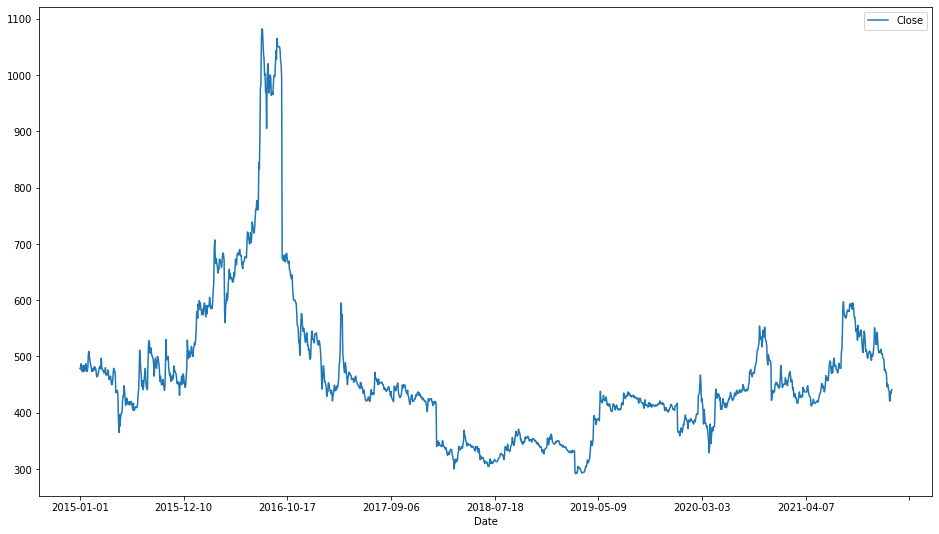

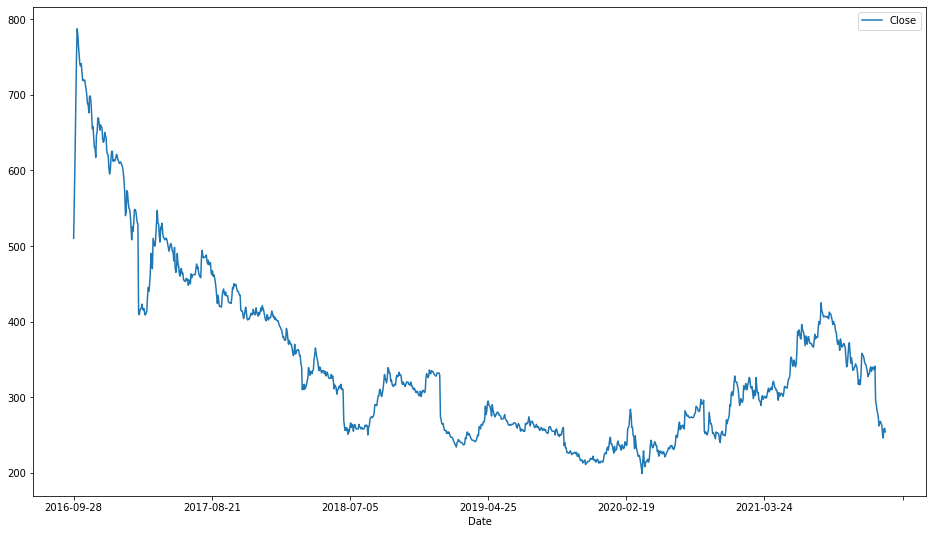

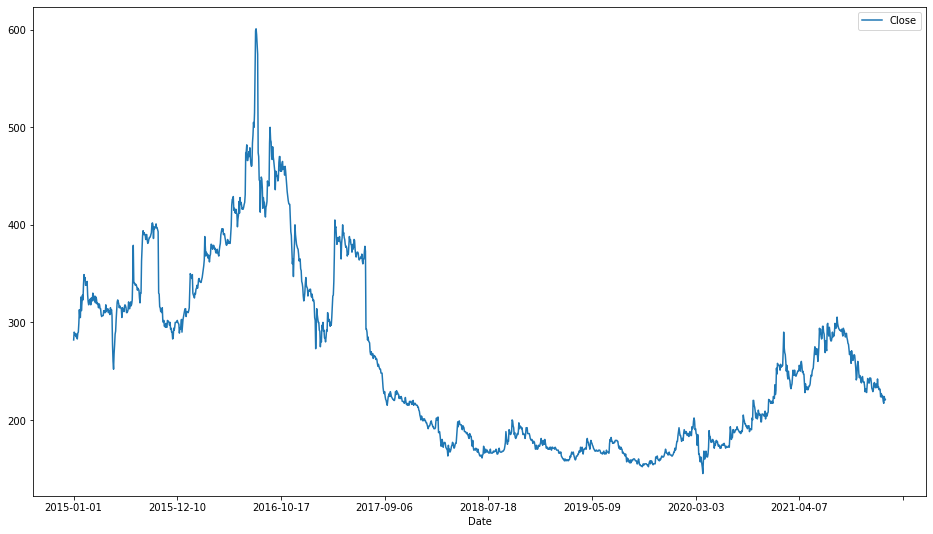

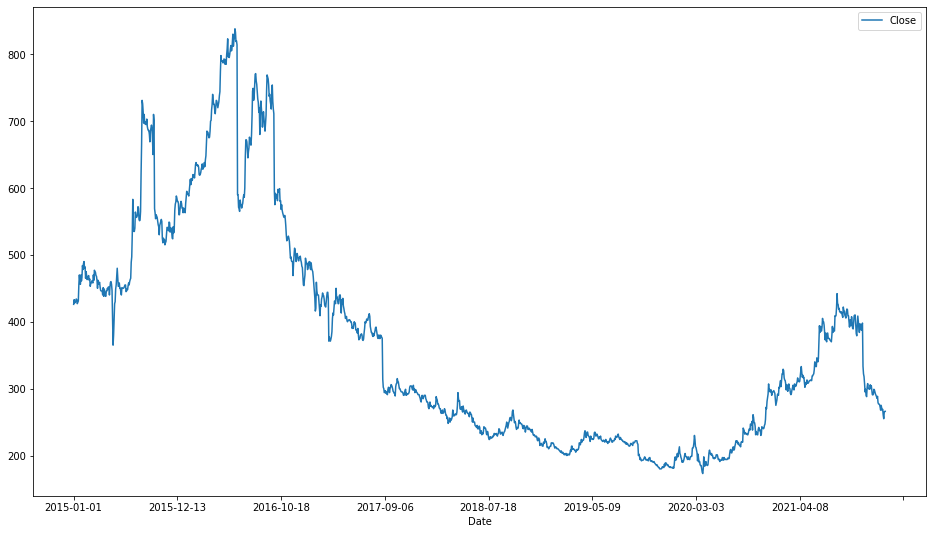

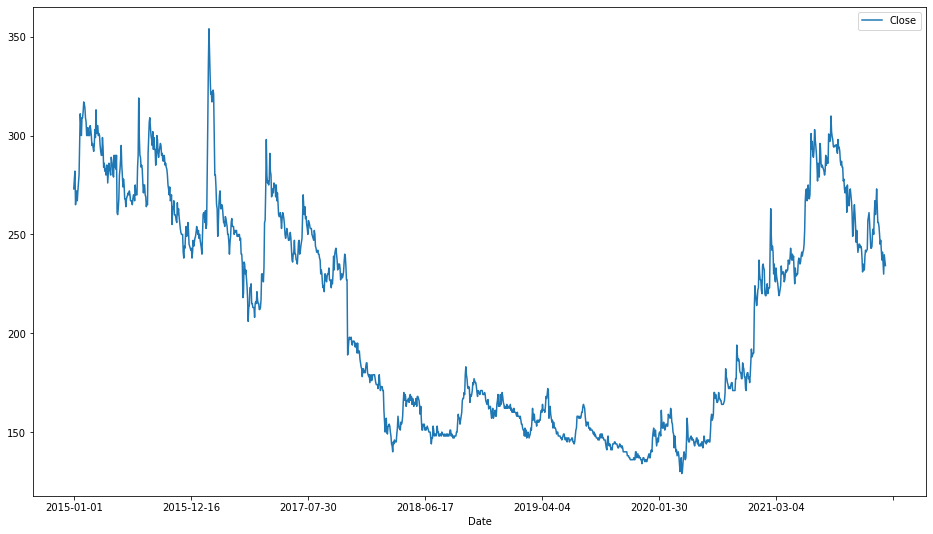

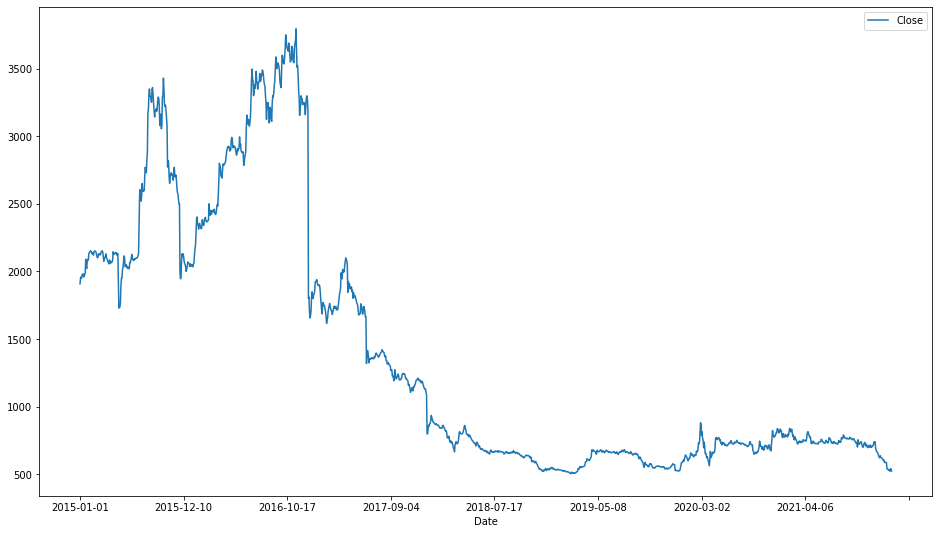

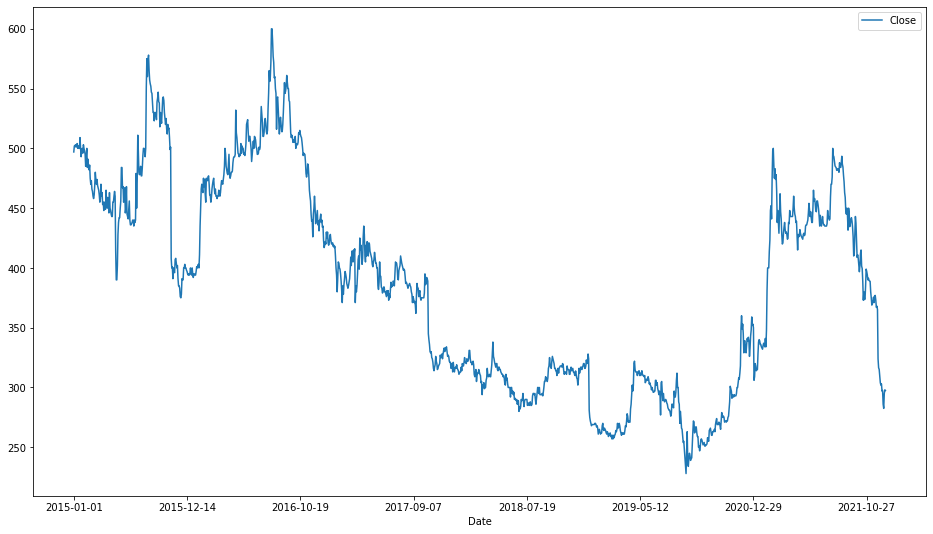

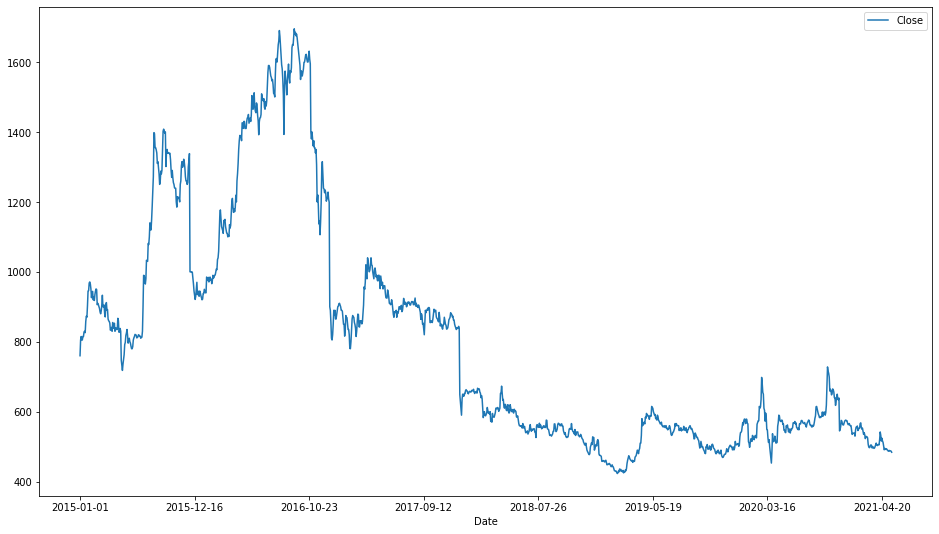

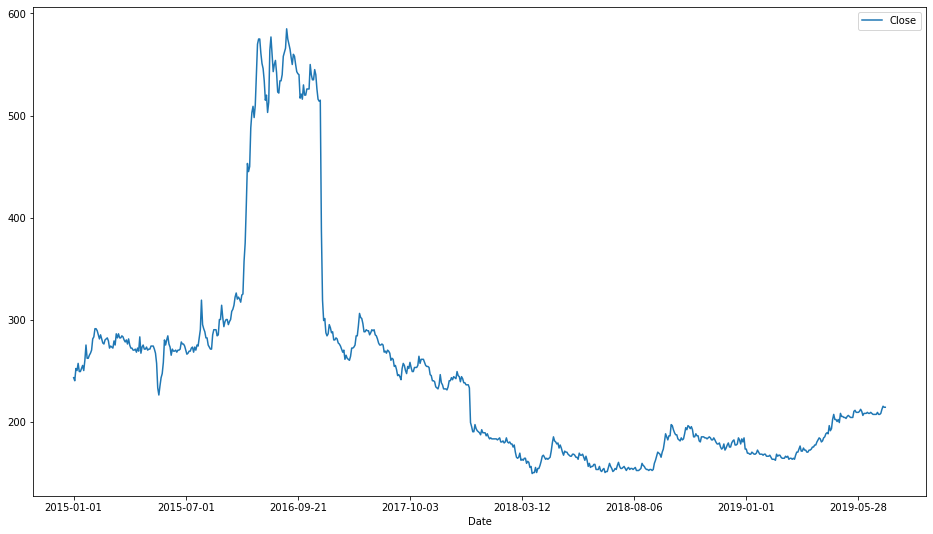

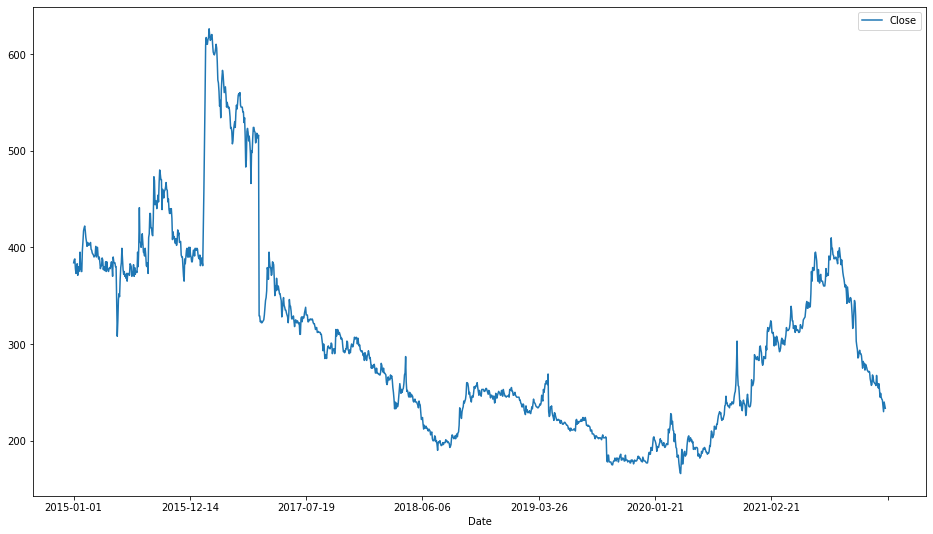

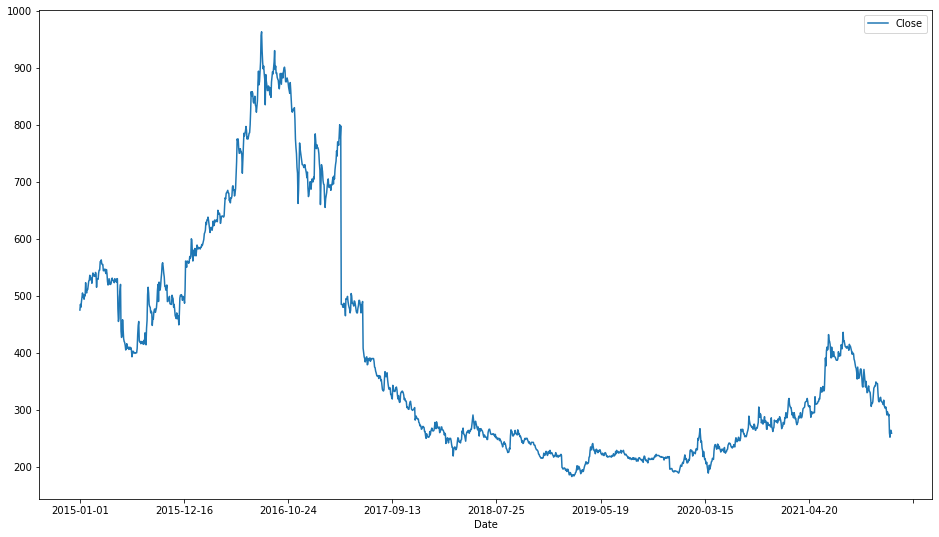

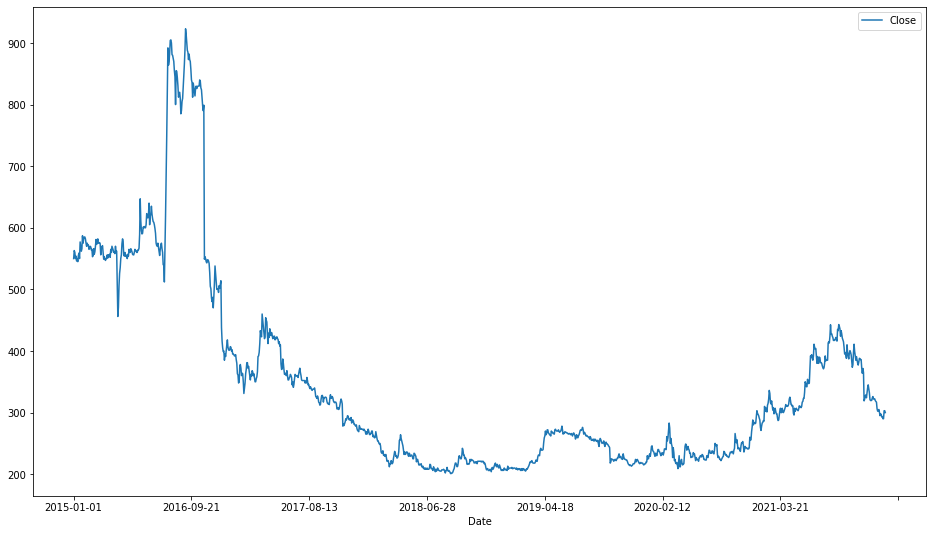

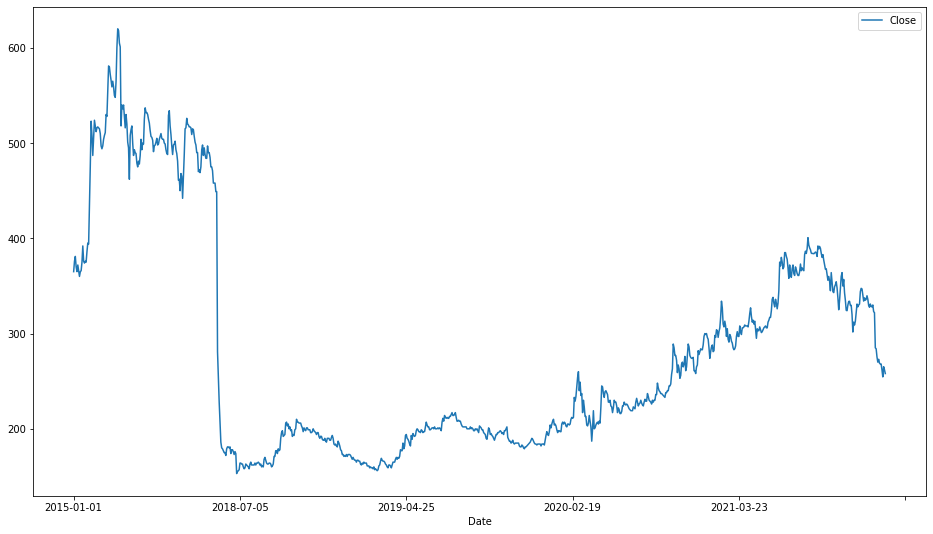

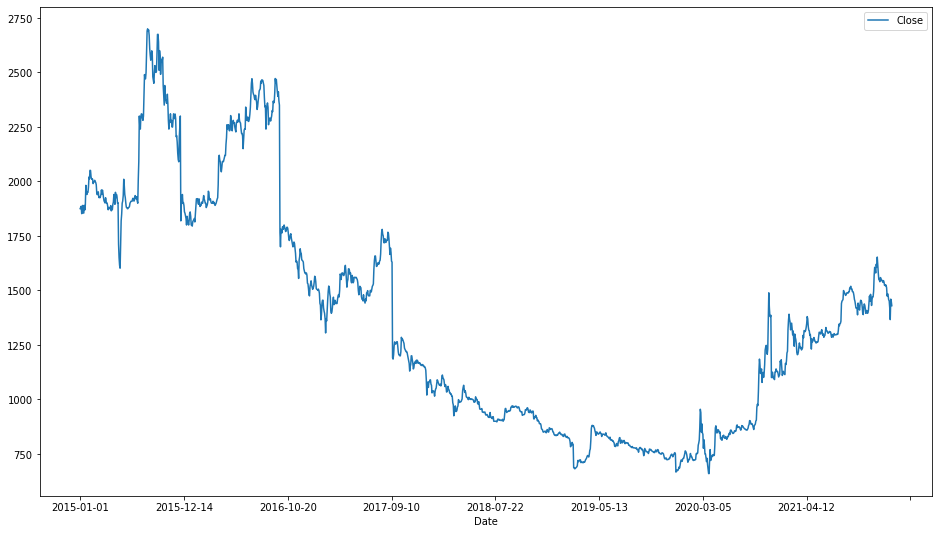

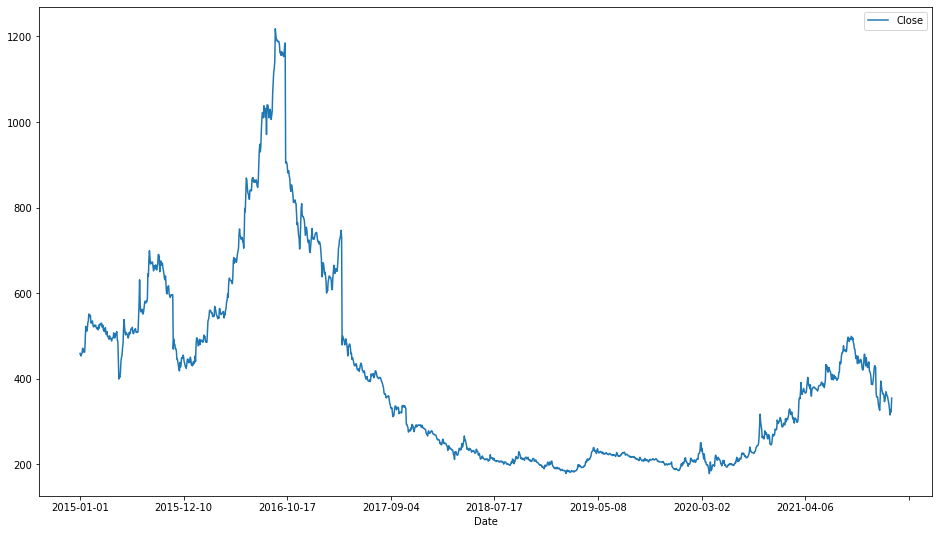

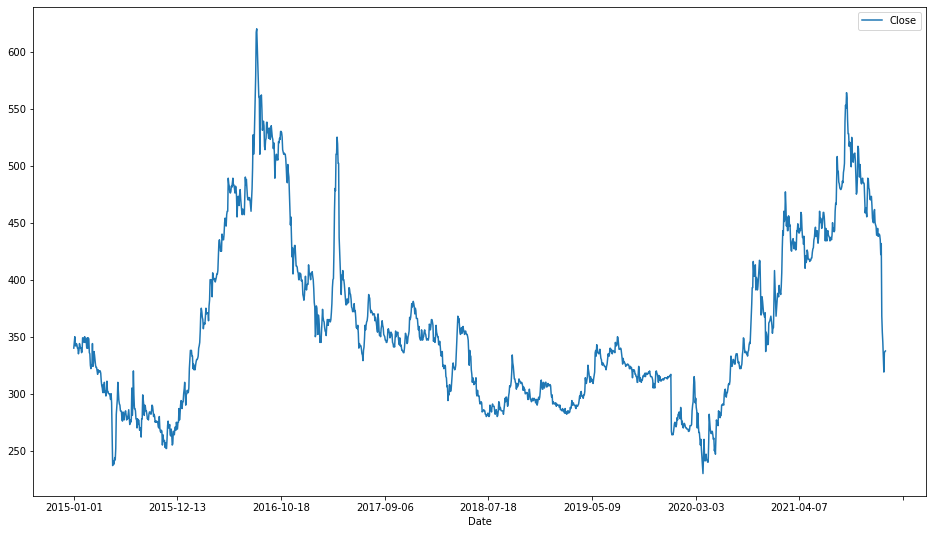

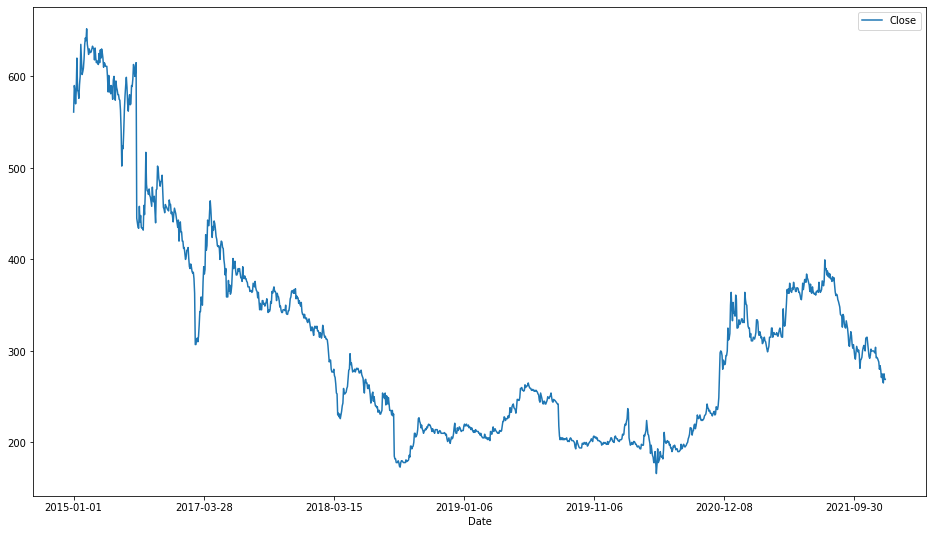

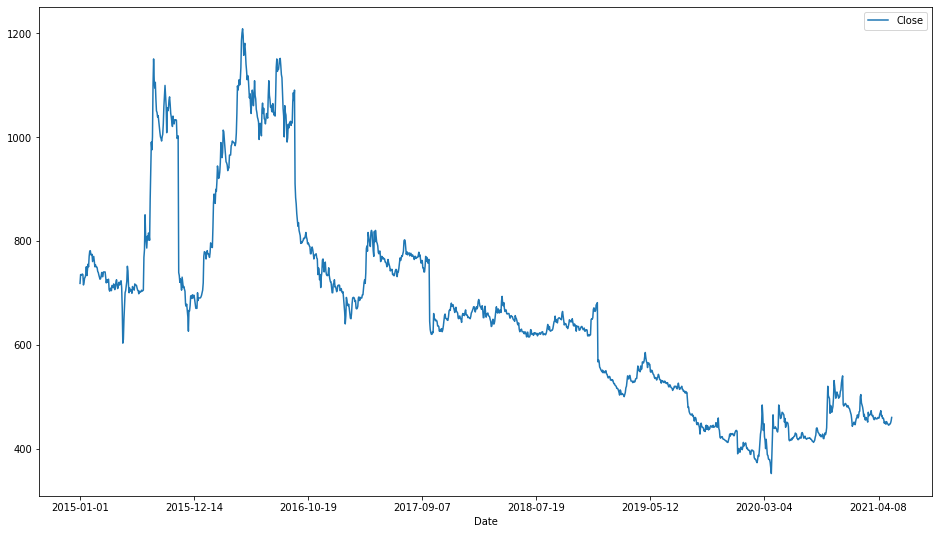

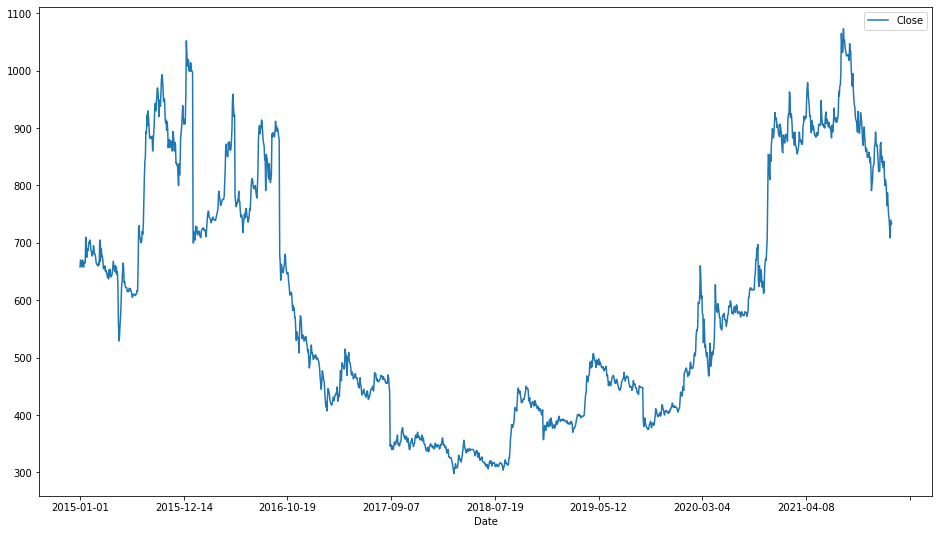

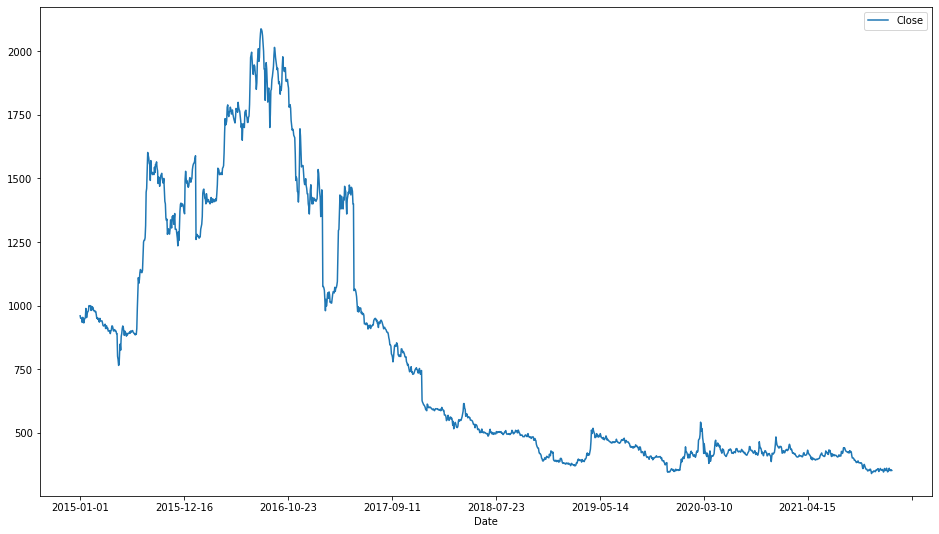

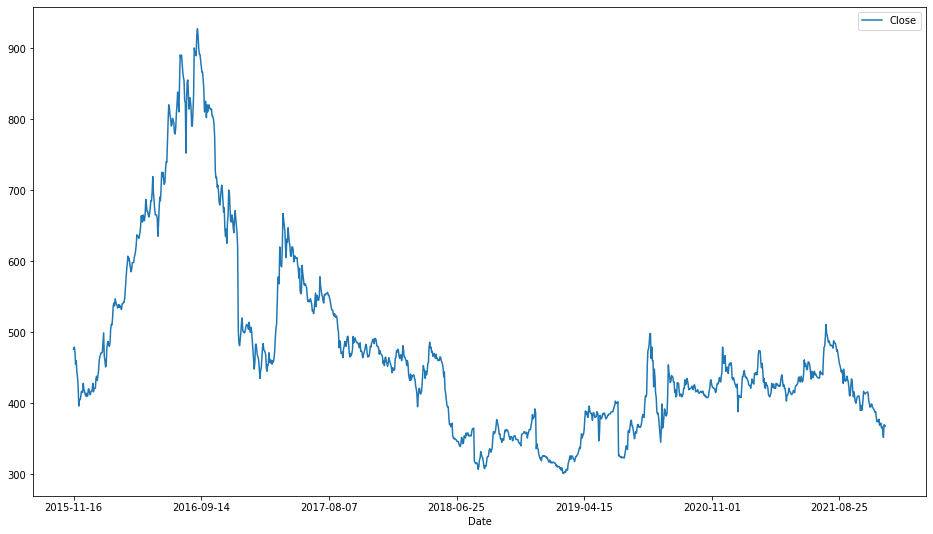

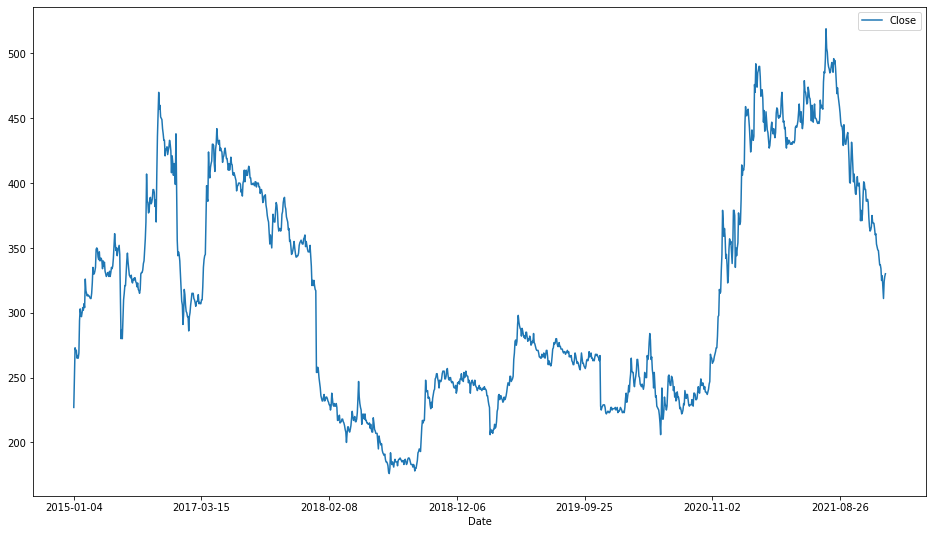

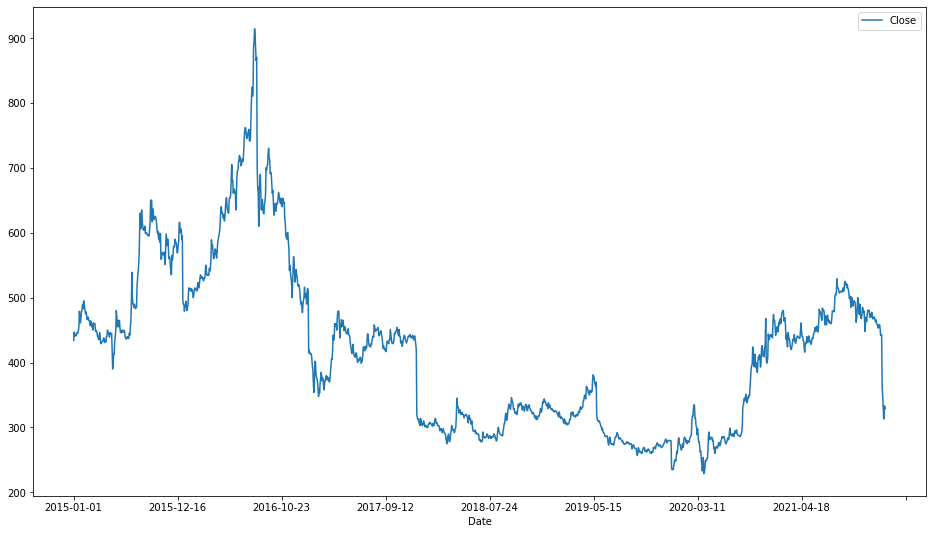

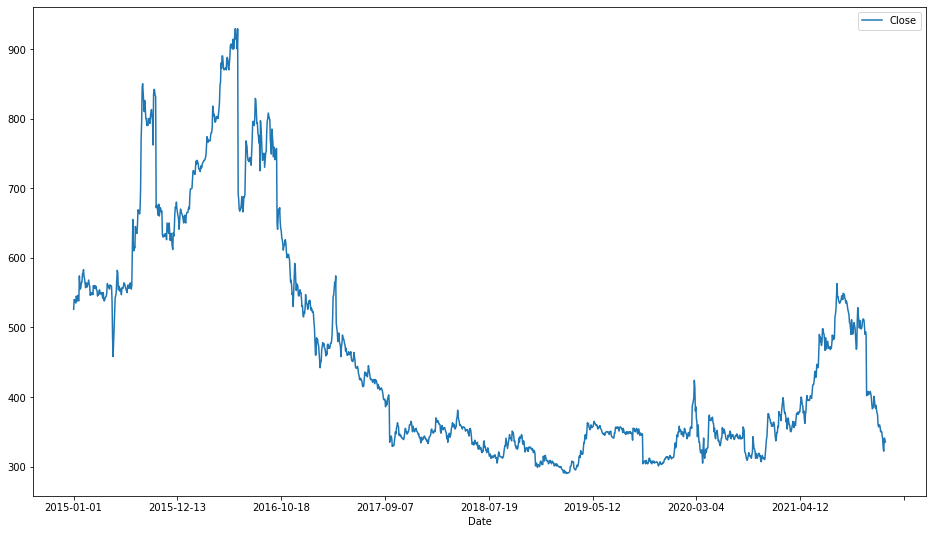

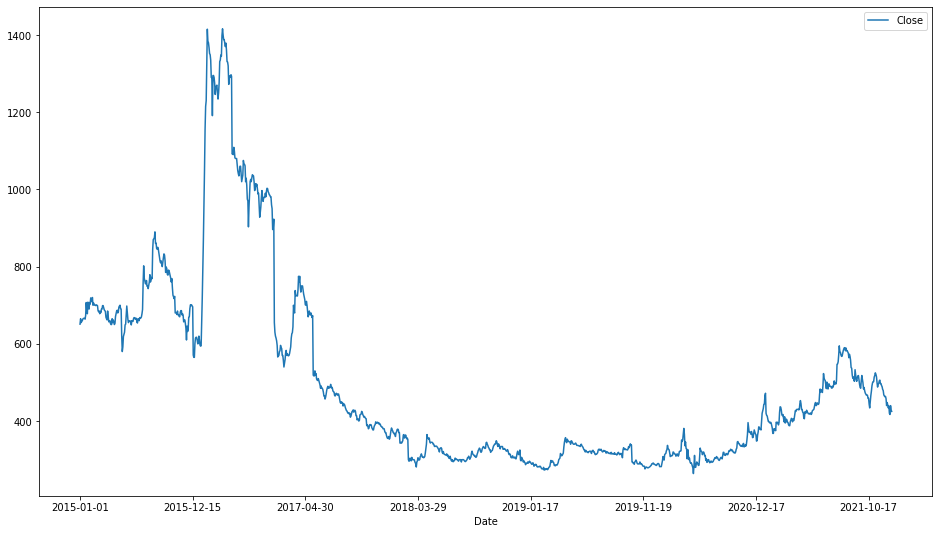

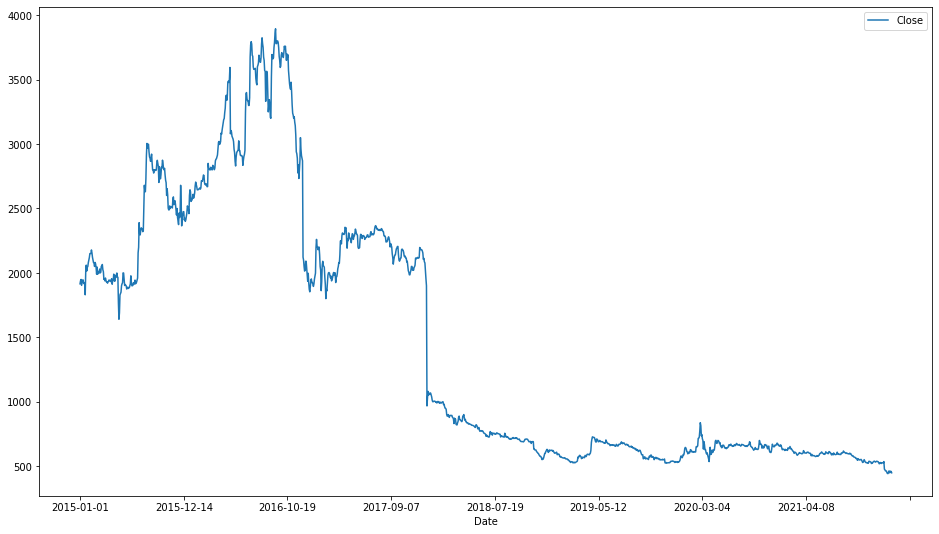

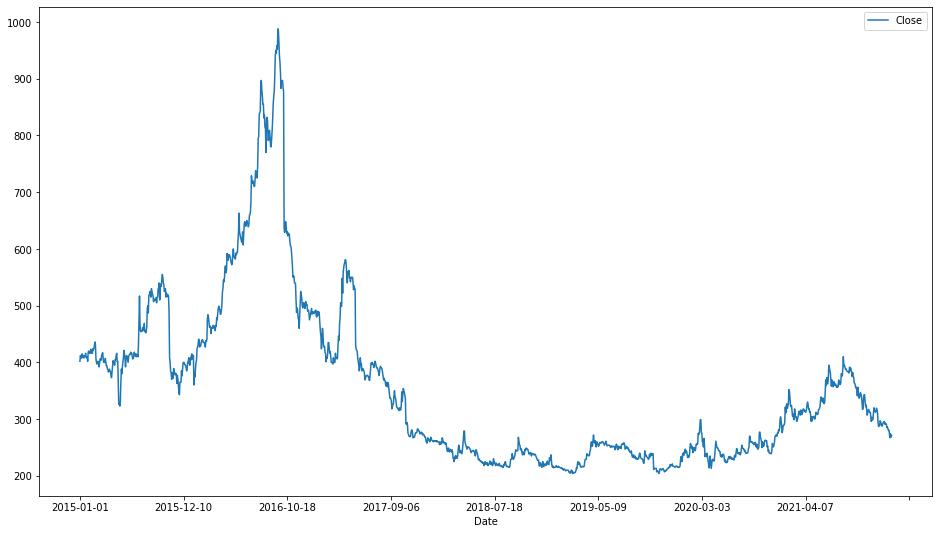

In [ ]:
for x,y in dictionary_company.items():
  print(x)
  print(y)
  #Getting the data
  company_name = x
  sector = y

  #company_name = "CIT"
  Start_date = "2015-01-01"
  company_df = price_history(company_name,Start_date)
  #print(company_df.head())
  #print(company_df.tail())

  #preparation of data for models
  data = data_for_model(company_df)
  X = data[1]
  Y = data[2]
  print("Working with BLSTM")
  #BLSTM
  start = time.time()
  model_BLSTM = Model_BLSTM(X,Y)
  Train_time = time.time()-start
  #Prediction
  start = time.time()
  record = model_prediction(data,model_BLSTM,company_df)
  Predict_time = time.time()-start
  #Error calculation
  error = MAPE(record)
  print(error)
  #save data
  save_record(company_name,sector,"BLSTM",Train_time,Predict_time,error)
  

  print("Working with LSTM")
  #LSTM
  start = time.time()
  model_LSTM = Model_LSTM(X,Y)
  Train_time = time.time()-start
  #Prediction
  start = time.time()
  record = model_prediction(data,model_LSTM,company_df)
  Predict_time = time.time()-start
  #Error calculation
  error = MAPE(record)
  print(error)
  #save data
  save_record(company_name,sector,"LSTM",Train_time,Predict_time,error)



  print("Working with GRU")
  #GRU
  start = time.time()
  model_GRU = Model_GRU(X,Y)
  Train_time = time.time()-start
  #Prediction
  start = time.time()
  record = model_prediction(data,model_GRU,company_df)
  Predict_time = time.time()-start
  #Error calculation
  error = MAPE(record)
  print(error)
  #save data
  save_record(company_name,sector,"GRU",Train_time,Predict_time,error)
              

  print("Working with BGRU")
  #BGRU
  start = time.time()
  model_BGRU = Model_BGRU(X,Y)
  Train_time = time.time()-start

  #Prediction
  start = time.time()
  record = model_prediction(data,model_BGRU,company_df)
  Predict_time = time.time()-start
  #Error calculation
  error = MAPE(record)
  print(error)
  #save data
  save_record(company_name,sector,"BGRU",Train_time,Predict_time,error)